In [23]:
import pandas as pd
import optuna
import warnings
import shap

from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from tqdm import tqdm_notebook
from datetime import datetime

warnings.filterwarnings("ignore")

In [2]:
from preprocessing import prep
from optimization import get_best_params, get_best_model_params
from config import DATA_PATH, MODEL_PATH, selected_feats, targets, MODEL_VERSION

In [3]:
def read_files(DATA_PATH):
    test_df = pd.read_csv(f'{DATA_PATH}/test_dataset_test.csv')
    train_df = pd.read_csv(f'{DATA_PATH}/train.csv')
    return train_df, test_df

In [4]:
train_df, test_df = read_files(DATA_PATH)

In [5]:
train_df = prep(train_df)
test_df = prep(test_df)

In [6]:
### FIT MODELS
for j, i in enumerate(targets):
    # TRAIN-VAL-SPLIT (random)
    tr_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df[i], random_state=123)
    if j == 0:
        cb = CatBoostClassifier(max_depth=3, learning_rate=0.01, eval_metric='AUC', verbose=1000, early_stopping_rounds=50)
    elif j == 3:
        cb = CatBoostClassifier(max_depth=2, eval_metric='AUC', verbose=1000, early_stopping_rounds=50)
    elif j == 1:
        cb = CatBoostClassifier(max_depth=2, n_estimators=300, eval_metric='AUC', verbose=1000, early_stopping_rounds=50)
    else:
        cb = CatBoostClassifier(max_depth=2, learning_rate=0.01, eval_metric='AUC', verbose=1000, early_stopping_rounds=50)
    train_pool = Pool(tr_df[selected_feats[i]], tr_df[i])
    val_pool = Pool(val_df[selected_feats[i]], val_df[i])
    test_pool = Pool(test_df[selected_feats[i]])
    cb.fit(train_pool, eval_set = val_pool)
    cb.save_model(f'{MODEL_PATH}/{i}_{MODEL_VERSION}.cbm')

0:	test: 0.7409121	best: 0.7409121 (0)	total: 47.8ms	remaining: 47.8s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7577109495
bestIteration = 7

Shrink model to first 8 iterations.
Learning rate set to 0.050059
0:	test: 0.4439891	best: 0.4439891 (0)	total: 1.17ms	remaining: 349ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6905737705
bestIteration = 64

Shrink model to first 65 iterations.
0:	test: 0.4259834	best: 0.4259834 (0)	total: 507us	remaining: 507ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7872670807
bestIteration = 229

Shrink model to first 230 iterations.
Learning rate set to 0.029651
0:	test: 0.7272032	best: 0.7272032 (0)	total: 459us	remaining: 459ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8061505508
bestIteration = 32

Shrink model to first 33 iterations.
0:	test: 0.4056795	best: 0.4056795 (0)	total: 456us	remaining: 456ms
Stopped by overfitting detector  (50 iterations w

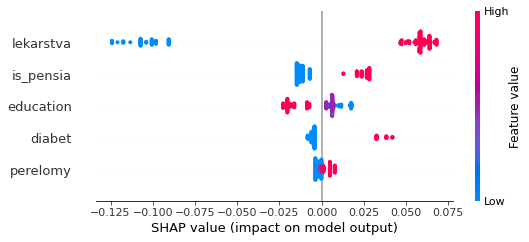

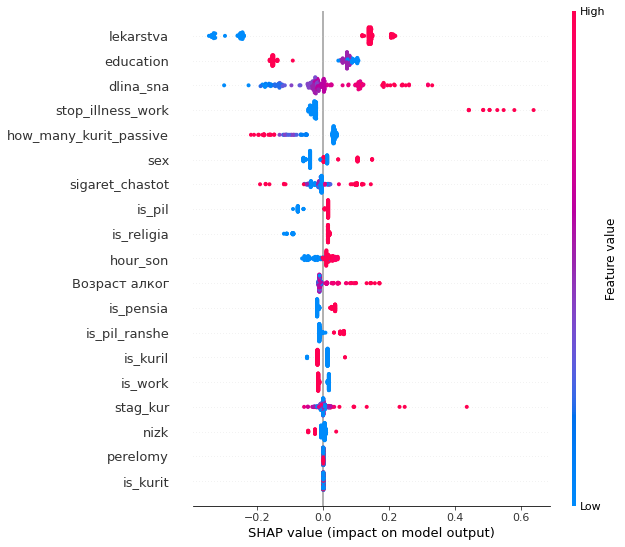

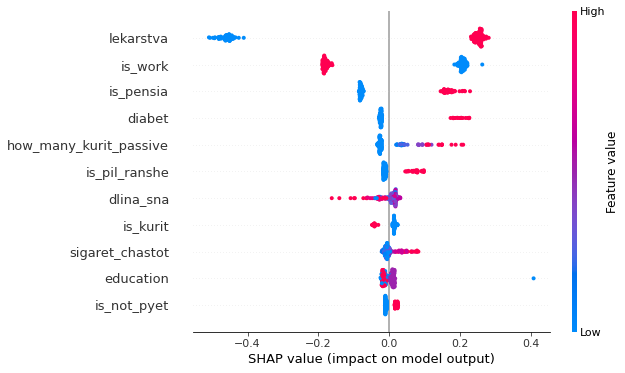

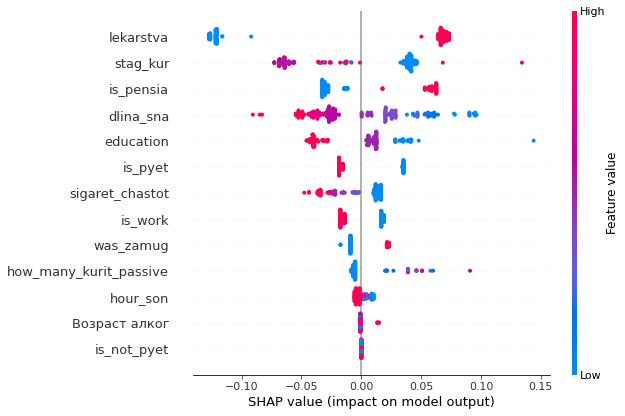

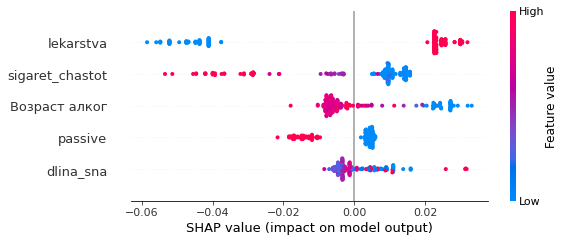

In [7]:
# Важные переменные
for j, i in enumerate(targets):
    tr_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df[i], random_state=123)
    b = CatBoostClassifier(max_depth=3, learning_rate=0.01, eval_metric='AUC', verbose=1000, early_stopping_rounds=50)
    train_pool = Pool(tr_df[selected_feats[i]], tr_df[i])
    val_pool = Pool(val_df[selected_feats[i]], val_df[i])
    test_pool = Pool(test_df[selected_feats[i]])
    cb.load_model(f'{MODEL_PATH}/{i}_{MODEL_VERSION}.cbm')
    shap.summary_plot(cb.get_feature_importance(val_pool, type='ShapValues')[:, :-1], val_df[cb.feature_names_])

**Артериальная гипертензия:*** 

Склонные люди: 
* Регулярно принимающие лекарства
* Пенсионеры
* Без высшего образования
* Больные сахарным диабетом
* Имебщие переломы

**ОНМК:**

Склонные люди:
* Регулярно принимающие лекарства
* Без высшего образования
* Долгая продолжительность ночного сна
* Прекратившие работу по болезни
* Мужчины
* Курящие (в т.ч. пассивно)
* Пьющие (в т.ч. бросившие)
* Неработающие

**Стенокардия, ИБС, инфаркт миокарда:**
* Регулярно принимающие лекарства
* Неработающие
* Пенсионеры
* Больные сахарным диабетом
* Пассивные курильщики
* Ранее употреблял алкоголь

**Сердечная недостаточность:**
* Регулярно принимающие лекарства
* Неработающие
* Недолгая продолжительность ночного сна
* Некурящие
* Пьющие
* Курящие пассивно
* Люди без высшего образования

**Прочие заболевания сердца:**
* Регулярно принимающие лекарства
* Курящие
* Курящие пассивно
* Женщины

In [8]:
def implement_model(val_df):
    cb = CatBoostClassifier()
    for i in targets:
        cb.load_model(f'{MODEL_PATH}/{i}_{MODEL_VERSION}.cbm')   
        val_pool = Pool(val_df[cb.feature_names_])
        val_df[f'sc_{i}'] = cb.predict_proba(val_pool)[:,1]
    return val_df

In [9]:
val_df = implement_model(val_df)
test_df = implement_model(test_df)

### Подберём пороги бинаризации

In [16]:
all_prs = []
all_scr = []
for i, target in enumerate(targets):
    prs, sc = get_best_params(val_df, target, 500, i, direction='maximize')
    all_prs.append(prs)
    all_scr.append(sc)

In [17]:
for number, (param, scor) in enumerate(zip(all_prs, all_scr)):
    print(f"""The best treshold for 
    target {targets[number]} is {param[f'param_{number}']:.4} with scor = {scor:.4}
    """)

The best treshold for 
    target Артериальная гипертензия is 0.4714 with scor = 0.741
    
The best treshold for 
    target ОНМК is 0.05684 with scor = 0.7144
    
The best treshold for 
    target Стенокардия, ИБС, инфаркт миокарда is 0.1446 with scor = 0.8145
    
The best treshold for 
    target Сердечная недостаточность is 0.2081 with scor = 0.7395
    
The best treshold for 
    target Прочие заболевания сердца is 0.3142 with scor = 0.6509
    


In [18]:
for j, i in enumerate(targets):
    test_df[i] = (test_df[f'sc_{i}']>all_prs[j][f'param_{j}'])
    val_df[i] = (val_df[f'sc_{i}']>all_prs[j][f'param_{j}'])

In [19]:
val_df[targets].mean()

Артериальная гипертензия              0.649215
ОНМК                                  0.193717
Стенокардия, ИБС, инфаркт миокарда    0.408377
Сердечная недостаточность             0.361257
Прочие заболевания сердца             0.607330
dtype: float64

In [20]:
test_df[targets].mean()

Артериальная гипертензия              0.606583
ОНМК                                  0.177116
Стенокардия, ИБС, инфаркт миокарда    0.365204
Сердечная недостаточность             0.278997
Прочие заболевания сердца             0.579937
dtype: float64

In [21]:
print('Scor on validate = ', round(sum(all_scr) / 5, 5))

Scor on validate =  0.73206


In [24]:
dt = str(datetime.today()).split()[0].replace('-','')[4:]

In [25]:
test_df[["ID"]+targets].to_csv(f'solution_{dt}_{MODEL_VERSION}.csv', index=False)

### PUBLIC SCORE = 0.710990